# Evaluation of GenAI Advisor Recommendations

**Date:** 2025-07-12

This notebook analyses the output of the batch backtesting pipeline. It evaluates the quality of recommendations made by the GenAI Advisor, focusing on signal performance, forward return analysis, and explanation quality.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load backtest results
df = pd.read_csv('batch_backtest_20250712_192926.csv')
df['as_of_date'] = pd.to_datetime(df['as_of_date'])
df.head()

,ticker,as_of_date,recommendation,reason,explanation,price_change_%
0,AAPL,2025-01-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,**Summary:** Hold onto AAPL for now.\n\n**Reas...,-3.22
1,AAPL,2025-02-01,BUY,Weighted signals support a BUY with a confiden...,**Summary:** I recommend buying AAPL (Apple In...,4.39
2,AAPL,2025-03-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,Summary: Hold onto your AAPL stocks for now.\n...,-6.68
3,AAPL,2025-04-01,BUY,Weighted signals support a BUY with a confiden...,**Summary:** Consider buying AAPL (Apple Inc.)...,-4.72
4,AAPL,2025-05-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,**Summary:** Hold onto AAPL for now.\n\n**Reas...,-2.19


## 1. Distribution of Recommendations

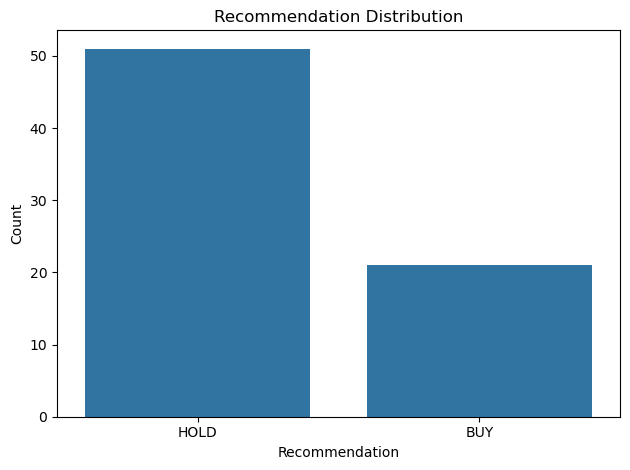

In [2]:
sns.countplot(data=df, x='recommendation')
plt.title('Recommendation Distribution')
plt.xlabel('Recommendation')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/recommendation_distribution.png')
plt.show()

## 2. Return Distribution per Recommendation

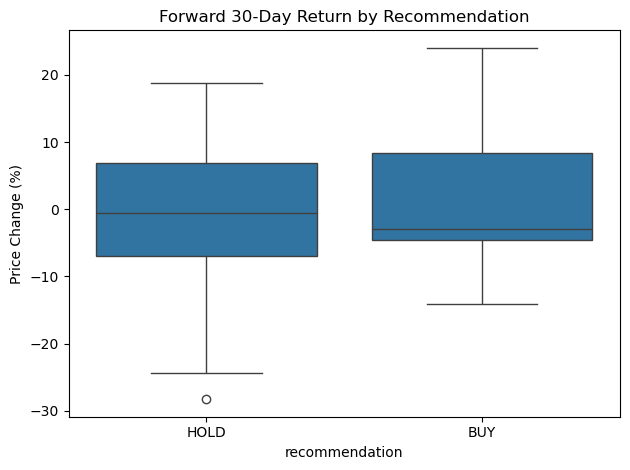

In [3]:
sns.boxplot(data=df, x='recommendation', y='price_change_%')
plt.title('Forward 30-Day Return by Recommendation')
plt.ylabel('Price Change (%)')
plt.tight_layout()
plt.savefig('figures/return_by_recommendation.png')
plt.show()

## 3. BUY Signal Accuracy

In [4]:
buy_df = df[df['recommendation'] == 'BUY']
buy_success_rate = (buy_df['price_change_%'] > 0).mean()
print(f'BUY signal success rate: {buy_success_rate:.2%}')

BUY signal success rate: 47.62%


## 4. Ticker-Level Return Analysis

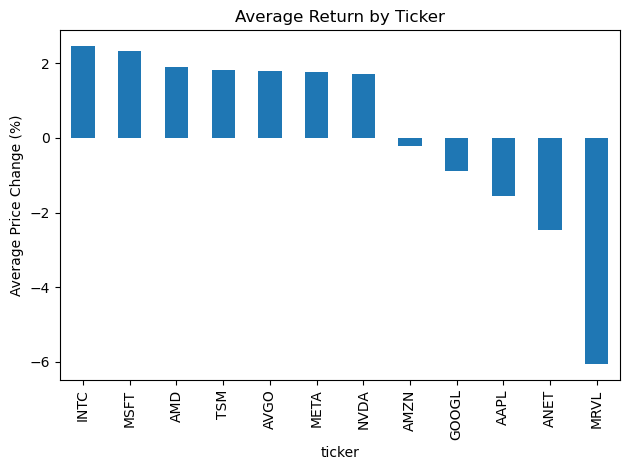

In [5]:
ticker_grouped = df.groupby('ticker')['price_change_%'].mean().sort_values(ascending=False)
ticker_grouped.plot(kind='bar', title='Average Return by Ticker')
plt.ylabel('Average Price Change (%)')
plt.tight_layout()
plt.savefig('figures/return_by_ticker.png')
plt.show()

## 5. Explanation Sample

In [6]:
df[['ticker', 'as_of_date', 'recommendation', 'explanation']].sample(3, random_state=42)

,ticker,as_of_date,recommendation,explanation
4,AAPL,2025-05-01,HOLD,**Summary:** Hold onto AAPL for now.\n\n**Reas...
62,ANET,2025-03-01,HOLD,**Summary:** HOLD on ANET for now.\n\n**Reason...
18,AMZN,2025-01-01,HOLD,**Summary:** Hold onto your Amazon (AMZN) stoc...


## 6. Summary Statistics by Recommendation

In [7]:
# Summary stats
summary = df.groupby('recommendation')['price_change_%'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
summary

,count,mean,median,std,min,max
recommendation,,,,,,
BUY,21,1.693333,-2.96,9.829472,-14.04,24.03
HOLD,51,-0.392745,-0.62,11.098703,-28.27,18.87


## 7. Cumulative Return Analysis (Simulated)

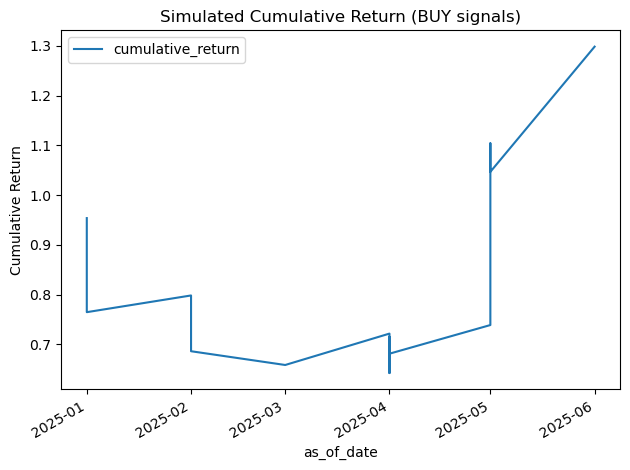

In [8]:
# Simulate equal-weighted cumulative return of all BUYs
buy_df = df[df['recommendation'] == 'BUY'].copy()
buy_df = buy_df.sort_values('as_of_date')
buy_df['cumulative_return'] = (1 + buy_df['price_change_%'] / 100).cumprod()
buy_df.plot(x='as_of_date', y='cumulative_return', title='Simulated Cumulative Return (BUY signals)')
plt.ylabel('Cumulative Return')
plt.tight_layout()
plt.savefig('figures/cumulative_buy_return.png')
plt.show()

## 8. Sharpe Ratio by Recommendation

In [9]:
# Annualised Sharpe Ratio (assumes 252 trading days)
sharpe = df.groupby('recommendation')['price_change_%'].agg(lambda x: x.mean() / x.std()) * (252 ** 0.5)
sharpe.name = 'Sharpe Ratio'
sharpe

recommendation
BUY     2.734718
HOLD   -0.561744
Name: Sharpe Ratio, dtype: float64

## 9. Signal Win Rates

In [10]:
# Win rate: % of signals that led to positive return
win_rates = df.groupby('recommendation')['price_change_%'].apply(lambda x: (x > 0).mean())
win_rates.name = 'Win Rate'
win_rates

recommendation
BUY     0.476190
HOLD    0.470588
Name: Win Rate, dtype: float64

## 10. Recommendation Heatmap by Ticker and Date

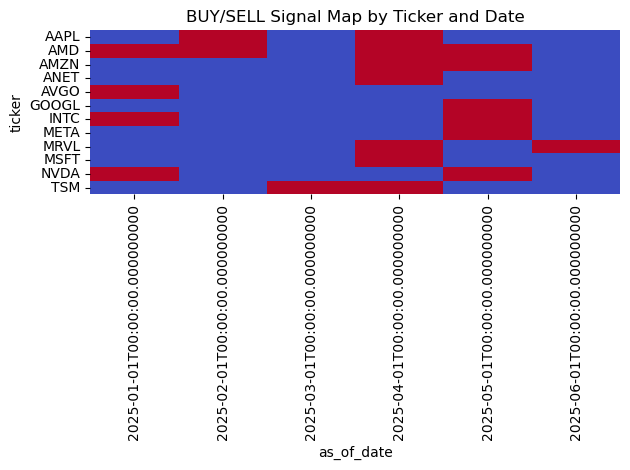

In [11]:
heatmap_df = df.pivot(index='ticker', columns='as_of_date', values='recommendation')
sns.heatmap(heatmap_df.isin(['BUY', 'SELL']), cmap='coolwarm', cbar=False)
plt.title('BUY/SELL Signal Map by Ticker and Date')
plt.tight_layout()
plt.savefig('figures/signal_heatmap.png')
plt.show()